### **Scaling Preprocessing**
- 0 ~ 1, -1 ~ 1, z-score 변환 중에서 한 개를 선택하여 범위를 축소하는 작업을 의미한다.
- Pretrained Model은 주로 tf와 torch 프레임워크 방식을 사용한다.
- tf는 -1 ~ 1, torch는 z-score 변환하는 것이 각 프레임워크의 전통이다.

<img src="./images/scaling.png" width="400" style="margin-top:20px;">

In [1]:
with open('./datasets/animals/translate.py') as f:
    content = f.readline()
    contents1 = eval(content[content.index('{'):content.index('}') + 1])
    contents2 = {v : k for k, v in contents1.items()}

print(contents1, contents2, sep='\n')

{'cane': 'dog', 'cavallo': 'horse', 'elefante': 'elephant', 'farfalla': 'butterfly', 'gallina': 'chicken', 'gatto': 'cat', 'mucca': 'cow', 'pecora': 'sheep', 'scoiattolo': 'squirrel', 'dog': 'cane', 'elephant': 'elefante', 'butterfly': 'farfalla', 'chicken': 'gallina', 'cat': 'gatto', 'cow': 'mucca', 'spider': 'ragno', 'squirrel': 'scoiattolo'}
{'dog': 'cane', 'horse': 'cavallo', 'elephant': 'elefante', 'butterfly': 'farfalla', 'chicken': 'gallina', 'cat': 'gatto', 'cow': 'mucca', 'sheep': 'pecora', 'squirrel': 'scoiattolo', 'cane': 'dog', 'elefante': 'elephant', 'farfalla': 'butterfly', 'gallina': 'chicken', 'gatto': 'cat', 'mucca': 'cow', 'ragno': 'spider', 'scoiattolo': 'squirrel'}


In [2]:
from glob import glob
import os

root = './datasets/animals/original/'

directories = glob(os.path.join(root, '*'))

for directory in directories:
    try:
        os.rename(directory, os.path.join(root, contents1[directory[directory.rindex('\\') + 1:]]))
    except KeyError as e:
        os.rename(directory, os.path.join(root, contents2[directory[directory.rindex('\\') + 1:]]))

In [3]:
root = './datasets/animals/original/'

directories = glob(os.path.join(root, '*'))
directory_names = []
for directory in directories:
    directory_names.append(directory[directory.rindex('\\') + 1:])

print(directory_names)

['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']


In [4]:
root = './datasets/animals/original/'

for name in directory_names:
    for i, file_name in enumerate(os.listdir(os.path.join(root, name))):
        old_file = os.path.join(root + name + '/', file_name)
        new_file = os.path.join(root + name + '/', name + str(i + 1) + '.png')

        os.rename(old_file, new_file)

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

idg = ImageDataGenerator(rescale=1./255)

generator = idg.flow_from_directory(root, target_size=(150, 150), batch_size=32, class_mode='categorical')
print(generator.class_indices)

Found 26179 images belonging to 10 classes.
{'butterfly': 0, 'cat': 1, 'chicken': 2, 'cow': 3, 'dog': 4, 'elephant': 5, 'horse': 6, 'sheep': 7, 'spider': 8, 'squirrel': 9}


In [6]:
target_name = {v: k for k, v in generator.class_indices.items()}
target_name

{0: 'butterfly',
 1: 'cat',
 2: 'chicken',
 3: 'cow',
 4: 'dog',
 5: 'elephant',
 6: 'horse',
 7: 'sheep',
 8: 'spider',
 9: 'squirrel'}

In [7]:
target_names = []
for target in generator.classes:
    target_names.append(target_name[target])

In [8]:
import pandas as pd
# scv 파일로 받았을 때
animal_df = pd.DataFrame({'file_paths': generator.filepaths, 'target_names': target_names, 'targets': generator.classes})
animal_df.file_paths = animal_df.file_paths.apply(lambda file_path: file_path.replace('\\', '/'))
animal_df

,file_paths,target_names,targets
0,./datasets/animals/original/butterfly/butterfl...,butterfly,0
1,./datasets/animals/original/butterfly/butterfl...,butterfly,0
2,./datasets/animals/original/butterfly/butterfl...,butterfly,0
3,./datasets/animals/original/butterfly/butterfl...,butterfly,0
4,./datasets/animals/original/butterfly/butterfl...,butterfly,0
...,...,...,...
26174,./datasets/animals/original/squirrel/squirrel9...,squirrel,9
26175,./datasets/animals/original/squirrel/squirrel9...,squirrel,9
26176,./datasets/animals/original/squirrel/squirrel9...,squirrel,9
26177,./datasets/animals/original/squirrel/squirrel9...,squirrel,9


In [9]:
from sklearn.model_selection import train_test_split

train_images, test_images, train_targets, test_targets = \
train_test_split(animal_df.file_paths, animal_df.targets, stratify=animal_df.targets,
                test_size=0.2, random_state=124)

print(train_targets.value_counts())

targets
4    3890
8    3857
2    2478
6    2098
0    1690
3    1493
9    1490
7    1456
1    1334
5    1157
Name: count, dtype: int64


In [11]:
from sklearn.model_selection import train_test_split

train_images, validation_images, train_targets, validation_targets = \
train_test_split(train_images, 
                 train_targets, 
                 stratify=train_targets, 
                 test_size=0.2, random_state=124)

print(train_targets.value_counts())
print(validation_targets.value_counts())
print(test_targets.value_counts())

targets
4    3112
8    3086
2    1982
6    1678
0    1352
3    1194
9    1192
7    1165
1    1067
5     926
Name: count, dtype: int64
targets
4    778
8    771
2    496
6    420
0    338
3    299
9    298
7    291
1    267
5    231
Name: count, dtype: int64
targets
4    973
8    964
2    620
6    525
0    422
3    373
9    372
7    364
1    334
5    289
Name: count, dtype: int64


In [12]:
train_df = animal_df.iloc[train_images.index].reset_index(drop=True)
validation_df = animal_df.iloc[validation_images.index].reset_index(drop=True)
test_df = animal_df.iloc[test_images.index].reset_index(drop=True)

print(train_df.shape)
print(validation_df.shape)
print(test_df.shape)

(16754, 3)
(4189, 3)
(5236, 3)


In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import albumentations as A

IMAGE_SIZE = 64
BATCH_SIZE = 64

def transform(image):
    aug = A.HorizontalFlip(p=0.5)

train_generator = ImageDataGenerator(preprocessing_function=transform, rescale=1./255)
validation_generator = ImageDataGenerator(rescale=1./255)
test_generator = ImageDataGenerator(rescale=1./255)

# flow_from_dataframe에서 y_col에 들어갈 타겟 데이터는 문자열 타입만 가능하다.
train_flow = train_generator.flow_from_dataframe(dataframe=train_df,
                                                x_col='file_paths',
                                                # 정수값이 아닌 문자열 값으로 받아야한다. targets -> target_names
                                                y_col='target_names',
                                                target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                class_mode='categorical',
                                                shuffle=True)

validation_flow = train_generator.flow_from_dataframe(dataframe=validation_df,
                                                x_col='file_paths',
                                                y_col='target_names',
                                                target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                class_mode='categorical')

test_flow = train_generator.flow_from_dataframe(dataframe=test_df,
                                                x_col='file_paths',
                                                y_col='target_names',
                                                target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                class_mode='categorical')

print(train_flow.class_indices)
print(validation_flow.class_indices)
print(test_flow.class_indices)

Found 16754 validated image filenames belonging to 10 classes.
Found 4189 validated image filenames belonging to 10 classes.
Found 5236 validated image filenames belonging to 10 classes.
{'butterfly': 0, 'cat': 1, 'chicken': 2, 'cow': 3, 'dog': 4, 'elephant': 5, 'horse': 6, 'sheep': 7, 'spider': 8, 'squirrel': 9}
{'butterfly': 0, 'cat': 1, 'chicken': 2, 'cow': 3, 'dog': 4, 'elephant': 5, 'horse': 6, 'sheep': 7, 'spider': 8, 'squirrel': 9}
{'butterfly': 0, 'cat': 1, 'chicken': 2, 'cow': 3, 'dog': 4, 'elephant': 5, 'horse': 6, 'sheep': 7, 'spider': 8, 'squirrel': 9}


In [16]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import Xception

def create_model(model_name='vgg16', verbose=False):
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    if model_name == 'vgg16':
        model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'resnet50': # ResNet50, 74.9% ; ResNet50V2, 76.0%
        model = ResNet50V2(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'xception': # Inception을 기초로 한 모델
        model = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')

    x = model.output

    # 분류기
    x = GlobalAveragePooling2D()(x)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    x = Dense(50, activation='relu')(x)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    output = Dense(10, activation='softmax', name='output')(x)
    
    model = Model(inputs=input_tensor, outputs=output)
    
    if verbose:
        model.summary()
    
    return model

In [17]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

model = create_model(model_name='xception', verbose=True)
model.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=['acc'])

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 64, 64, 3)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv1 (Conv2D)         │ (None, 31, 31, 32)        │             864 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv1_bn               │ (None, 31, 31, 32)        │             128 │ block1_conv1[0][0]         │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv1_act (Activation) │ (None, 31, 31, 32)        │               0 │ block1_conv1_bn[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv2 (Conv2D)         │ (None, 29, 29, 64)        │          18,432 │ block1_conv1_act[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv2_bn               │ (None, 29, 29, 64)        │             256 │ block1_conv2[0][0]         │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv2_act (Activation) │ (None, 29, 29, 64)        │               0 │ block1_conv2_bn[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv1               │ (None, 29, 29, 128)       │           8,768 │ block1_conv2_act[0][0]     │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv1_bn            │ (None, 29, 29, 128)       │             512 │ block2_sepconv1[0][0]      │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv2_act           │ (None, 29, 29, 128)       │               0 │ block2_sepconv1_bn[0][0]   │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv2               │ (None, 29, 29, 128)       │          17,536 │ block2_sepconv2_act[0][0]  │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv2_bn            │ (None, 29, 29, 128)       │             512 │ block2_sepconv2[0][0]      │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 15, 15, 128)       │           8,192 │ block1_conv2_act[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_pool (MaxPooling2D)    │ (None, 15, 15, 128)       │               

 Total params: 20,964,440 (79.97 MB)

 Trainable params: 20,909,912 (79.76 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.losses import CategoricalCrossentropy

mcp_cb = ModelCheckpoint(
    filepath="./callback_files/weights.{epoch:03d}-{val_loss:.4f}-{acc:.4f}.weights.h5",
    monitor='val_loss',
    save_best_only=False,
    save_weights_only=True,
    mode='min'
)

rlr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    mode='min'
)

ely_cb = EarlyStopping(
    monitor='val_loss',
    patience=4,
    mode='min'
)

In [19]:
import gc

gc.collect()

26

In [20]:
N_EPOCHS = 10

history = model.fit(train_flow, 
                    batch_size=BARCH_SIZE, 
                    epochs=N_EPOCHS, 
                    validation_data=validation_flow, 
                    callbacks=[mcp_cb, rlr_cb, ely_cb])

NameError: name 'BARCH_SIZE' is not defined

In [21]:
model.evaluate(test_flow)

TypeError: unsupported operand type(s) for *=: 'NoneType' and 'float'

In [ ]:
import matplotlib.pyplot as plt

def show_history(history):
    plt.figure(figsize=(6, 6))
    plt.yticks(np.arange(0, 1, 0.05))
    plt.plot(history.history['acc'], label='train')
    plt.plot(history.history['val_acc'], label='validation')
    plt.legend()
    
show_history(history)

### Scaling

In [22]:
def preprocessing_scaling(image, mode='tf'):
    if mode == 'tf': # -1 ~ 1 scale
        image = image / 127.5
        image -= 1.
    
    elif mode == 'torch': # z-score scale
        image = image / 255.
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        
        image[:, :, 0] = (image[:, :, 0] - mean[0])/std[0]
        image[:, :, 1] = (image[:, :, 1] - mean[1])/std[1]
        image[:, :, 2] = (image[:, :, 2] - mean[2])/std[2]
        
    return image

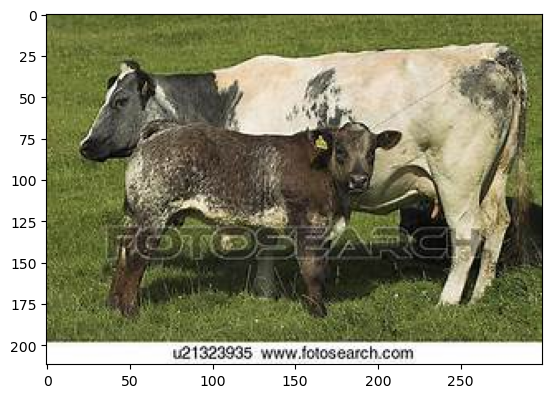

In [24]:
import cv2
import matplotlib.pyplot as plt

image = cv2.cvtColor(cv2.imread(train_df.file_paths.iloc[16749]), cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

In [25]:
scaled_image_tf = preprocessing_scaling(image, mode='tf')
scaled_image_torch = preprocessing_scaling(image, mode='torch')

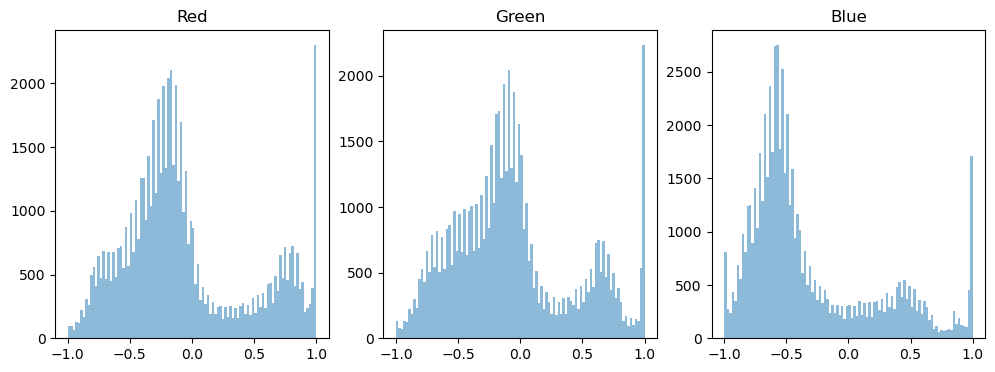

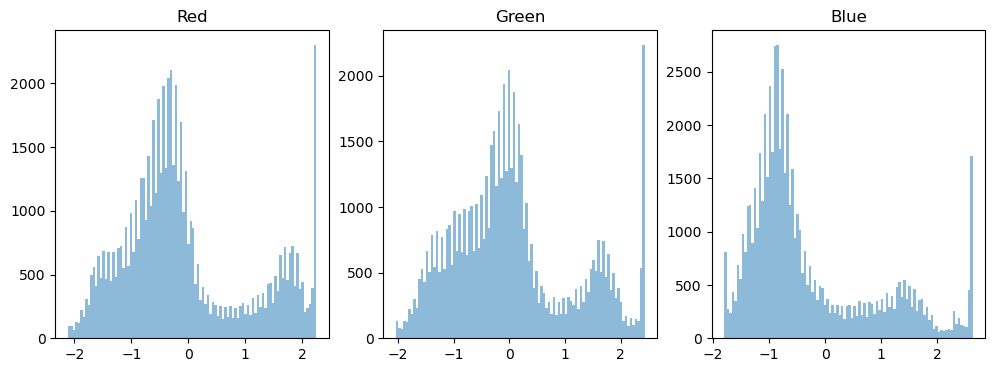

In [26]:
def show_pixel_histogram(image):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
    titles = ['Red', 'Green', 'Blue']
    for i in range(3):
        axs[i].hist(image[:, :, i].flatten(), bins=100, alpha=0.5)
        title_str = titles[i]
        axs[i].set(title=title_str)

show_pixel_histogram(scaled_image_tf)
show_pixel_histogram(scaled_image_torch)

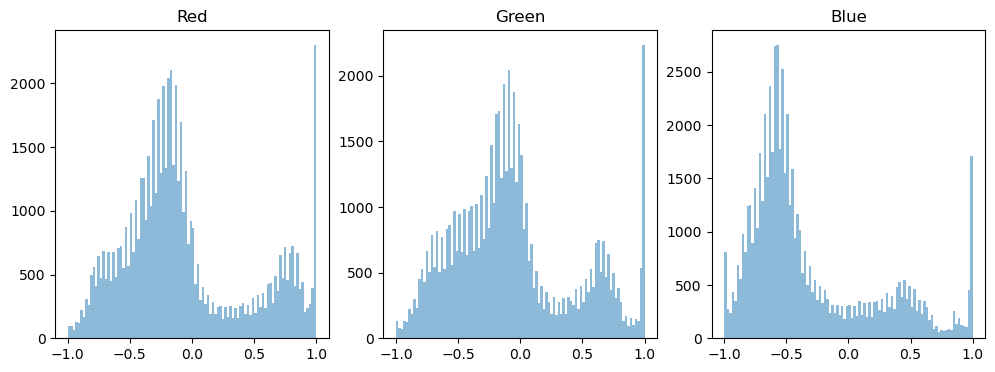

In [27]:
from tensorflow.keras.applications.xception import preprocess_input

# Xception의 scaling 방식은 tf
scaled_image_xception = preprocess_input(image)
show_pixel_histogram(scaled_image_xception)

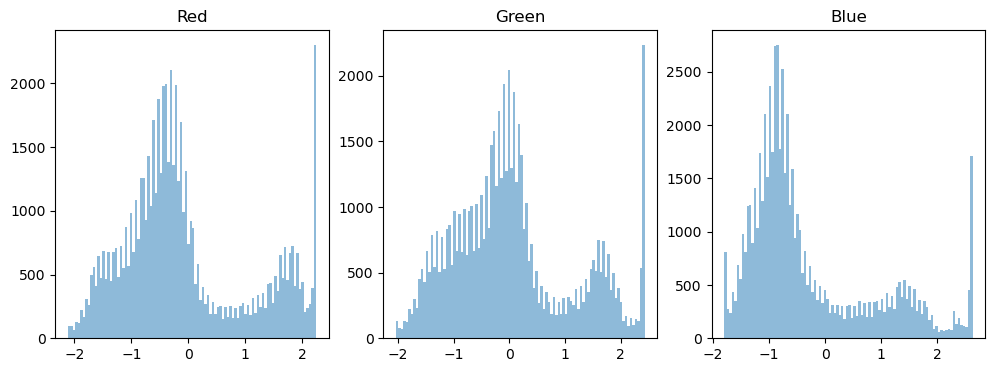

In [28]:
from tensorflow.keras.applications.densenet import preprocess_input

# DenseNet의 scaling 방식은 torch
scaled_image_densnet = preprocess_input(image)
show_pixel_histogram(scaled_image_densnet)

In [29]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import albumentations as A

IMAGE_SIZE = 64
BATCH_SIZE = 64

def preprocessing_scaling_for_train(image, mode='tf'):
    aug = A.HorizontalFlip(p=0.5)
    image = aug(image=image)['image']
    
    if mode == 'tf': # -1 ~ 1 scale
        image = image / 127.5
        image -= 1.
    
    elif mode == 'torch': # z-score scale
        image = image / 255.
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        
        image[:, :, 0] = (image[:, :, 0] - mean[0])/std[0]
        image[:, :, 1] = (image[:, :, 1] - mean[1])/std[1]
        image[:, :, 2] = (image[:, :, 2] - mean[2])/std[2]
        
    return image

def preprocessing_scaling(image, mode='tf'):
    if mode == 'tf': # -1 ~ 1 scale
        image = image / 127.5
        image -= 1.
    
    elif mode == 'torch': # z-score scale
        image = image / 255.
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        
        image[:, :, 0] = (image[:, :, 0] - mean[0])/std[0]
        image[:, :, 1] = (image[:, :, 1] - mean[1])/std[1]
        image[:, :, 2] = (image[:, :, 2] - mean[2])/std[2]
        
    return image

train_generator = ImageDataGenerator(preprocessing_function=preprocessing_scaling_for_train)
validation_generator = ImageDataGenerator(preprocessing_function=preprocessing_scaling)
test_generator = ImageDataGenerator(preprocessing_function=preprocessing_scaling)

train_flow = train_generator.flow_from_dataframe(dataframe=train_df, 
                                                 x_col='file_paths', 
                                                 y_col='target_names',
                                                 target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                 class_mode='categorical',
                                                 shuffle=True)

validation_flow = validation_generator.flow_from_dataframe(dataframe=validation_df, 
                                                 x_col='file_paths', 
                                                 y_col='target_names',
                                                 target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                 class_mode='categorical')

test_flow = test_generator.flow_from_dataframe(dataframe=test_df, 
                                                 x_col='file_paths', 
                                                 y_col='target_names',
                                                 target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                 class_mode='categorical')

print(train_flow.class_indices)
print(validation_flow.class_indices)
print(test_flow.class_indices)

Found 16754 validated image filenames belonging to 10 classes.
Found 4189 validated image filenames belonging to 10 classes.
Found 5236 validated image filenames belonging to 10 classes.
{'butterfly': 0, 'cat': 1, 'chicken': 2, 'cow': 3, 'dog': 4, 'elephant': 5, 'horse': 6, 'sheep': 7, 'spider': 8, 'squirrel': 9}
{'butterfly': 0, 'cat': 1, 'chicken': 2, 'cow': 3, 'dog': 4, 'elephant': 5, 'horse': 6, 'sheep': 7, 'spider': 8, 'squirrel': 9}
{'butterfly': 0, 'cat': 1, 'chicken': 2, 'cow': 3, 'dog': 4, 'elephant': 5, 'horse': 6, 'sheep': 7, 'spider': 8, 'squirrel': 9}
